# Part 2: Modelling with ARIMA and Linear Regression

This section will focus on creating basic models to predict COE premiums. After the model is created, I will evaluate the models using MSE.

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    LassoCV,
    Ridge,
    RidgeCV,
)

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import (
    train_test_split,
    cross_val_score
)

from sklearn.preprocessing import (
    StandardScaler
)

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
# Importing datasets
coe = pd.read_csv('../data/merged_cat_a.csv')
coe_lag = pd.read_csv('../data/merged_cat_a_lag.csv')

In [3]:
# Convert dates to datetime format
coe['date'] = pd.to_datetime(coe['date'])
coe['new_date'] = pd.to_datetime(coe['new_date'])

In [4]:
coe

,bidding_exercise,date,year,category,premium,quota,total_bids_received,number_of_successful_bids,quarter,month,...,total_pop,pop_density,total_pop_growth,average_income,median_income,average_employed_income,median_employed_income,close,air_departures,birth_rate
0,April 2022 Second Open Bidding Exercise,2022-04-20,2022,cat_a,68699.0,532.0,744.0,519.0,2,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,April 2022 First Open Bidding Exercise,2022-04-06,2022,cat_a,72996.0,536.0,723.0,536.0,2,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3419.11,NaN,NaN
2,March 2022 Second Open Bidding Exercise,2022-03-23,2022,cat_a,71556.0,543.0,849.0,542.0,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3236.04,565823.0,NaN
3,March 2022 First Open Bidding Exercise,2022-03-09,2022,cat_a,68501.0,531.0,962.0,526.0,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3278.63,565823.0,NaN
4,February 2022 Second Open Bidding Exercise,2022-02-23,2022,cat_a,63000.0,536.0,876.0,524.0,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3421.38,334406.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,April 2020 Second Open Bidding Exercise,2020-04-15,2020,cat_a,31210.0,982.0,1421.0,962.0,2,4,...,5685807.0,7810.0,-0.3,9634.0,6810.0,11111.0,8092.0,2605.56,17340.0,8.5
478,May 2020 First Open Bidding Exercise,2020-05-01,2020,cat_a,31210.0,982.0,1421.0,962.0,2,5,...,5685807.0,7810.0,-0.3,9634.0,6810.0,11111.0,8092.0,NaN,20400.0,8.5
479,May 2020 Second Open Bidding Exercise,2020-05-15,2020,cat_a,31210.0,982.0,1421.0,962.0,2,5,...,5685807.0,7810.0,-0.3,9634.0,6810.0,11111.0,8092.0,2523.55,20400.0,8.5
480,June 2020 First Open Bidding Exercise,2020-06-01,2020,cat_a,31210.0,982.0,1421.0,962.0,2,6,...,5685807.0,7810.0,-0.3,9634.0,6810.0,11111.0,8092.0,2550.86,34190.0,8.5


In [5]:
coe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482 entries, 0 to 481
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   bidding_exercise           482 non-null    object        
 1   date                       482 non-null    datetime64[ns]
 2   year                       482 non-null    int64         
 3   category                   482 non-null    object        
 4   premium                    482 non-null    float64       
 5   quota                      482 non-null    float64       
 6   total_bids_received        482 non-null    float64       
 7   number_of_successful_bids  482 non-null    float64       
 8   quarter                    482 non-null    int64         
 9   month                      482 non-null    int64         
 10  day                        482 non-null    int64         
 11  new_date                   482 non-null    datetime64[ns]
 12  total_mo

## Baseline Model - ARIMA

For my first model, as this is a time series model, I will be trying out a simple ARIMA model.

In [6]:
# Creating an df to be used for ARIMA model
df = coe[['premium', 'new_date']]
df['new_date']

0     2022-04-15
1     2022-04-01
2     2022-03-15
3     2022-03-01
4     2022-02-15
         ...    
477   2020-04-15
478   2020-05-01
479   2020-05-15
480   2020-06-01
481   2020-06-15
Name: new_date, Length: 482, dtype: datetime64[ns]

In [7]:
# Setting the index to be the date
df.set_index('new_date',inplace=True)
df.sort_index(inplace=True)

/var/folders/0t/nymtt02n1zqdc1ksr0n857bc0000gn/T/ipykernel_5821/2894332124.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_index(inplace=True)


In [8]:
df

,premium
new_date,
2002-04-01,37201.0
2002-04-15,36000.0
2002-05-01,35000.0
2002-05-15,33401.0
2002-06-01,33009.0
...,...
2022-02-15,63000.0
2022-03-01,68501.0
2022-03-15,71556.0


In [9]:
# Adding a frequency to the dataset.
df = df.resample('SMS').mean()

### Stationarity Test - Dickey-Fuller Test

To test whether the data is stationary, I will apply the dickey-fuller test to the COE premium.

In [10]:
# Differenciating the data once
df['premium'].diff()

new_date
2002-04-01       NaN
2002-04-15   -1201.0
2002-05-01   -1000.0
2002-05-15   -1599.0
2002-06-01    -392.0
               ...  
2022-02-15    2239.0
2022-03-01    5501.0
2022-03-15    3055.0
2022-04-01    1440.0
2022-04-15   -4297.0
Freq: SMS-15, Name: premium, Length: 482, dtype: float64

In [11]:
# Using the dickey-fuller test
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [12]:
interpret_dftest(adfuller(df['premium']))

Test Statistic   -1.050243
p-value           0.734501
dtype: float64

For the undifferenciated data, the p-value is 0.734. Hence, we are unable to reject the null hypothesis which was that the data series is not stationary.

In [13]:
interpret_dftest(adfuller(df['premium'].diff().dropna()))

Test Statistic   -23.909607
p-value            0.000000
dtype: float64

For the once differenciated data, the p-value is 0.000. Hence, we are able to reject the null hypothesis and accept the alternative hypothesis that the data is stationary. 

As such, we will be able to use the once-differenced data for time series modelling

In [14]:
interpret_dftest(adfuller(df['premium'].diff().diff().dropna()))

Test Statistic   -1.149700e+01
p-value           4.588372e-21
dtype: float64

Checking on the twice differenciated data, the p-value is even lower. However, it is unnecessary as the once differenciated data is sufficient to proof stationarity.

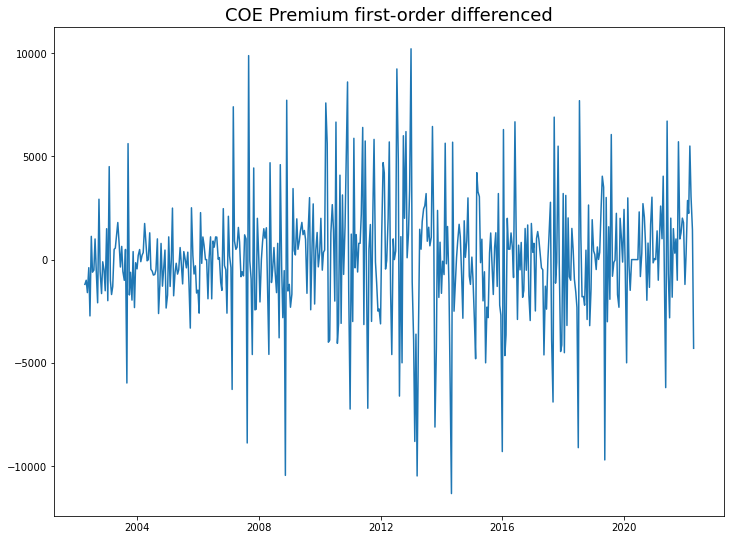

In [15]:
# Plotting stationarity check for once differenced coe premium
plt.figure(figsize=(12,9))
plt.plot(df['premium'].diff())
plt.title('COE Premium first-order differenced', fontsize=18);

Next I also checked the ACF and PACF plots for COE premium

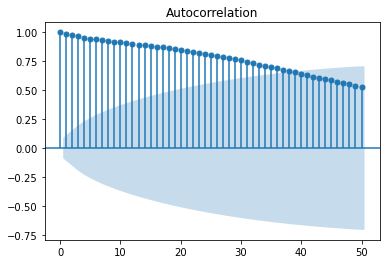

In [16]:
plot_acf(df['premium'], lags=50);

The ACF plot on undifferentiated data shows that the series is highly correlated to past values. Hence there is a need to use the differenced data instead.

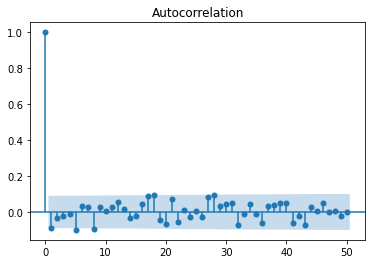

In [17]:
plot_acf(df['premium'].diff().dropna(), lags=50);

There are not much significant spikes at the various lags. There are some that may seem to be significant at lags 1, 5, 8, 17 and 18. Although they are not very strong signals, we can stil use them to test in the ARIMA model.

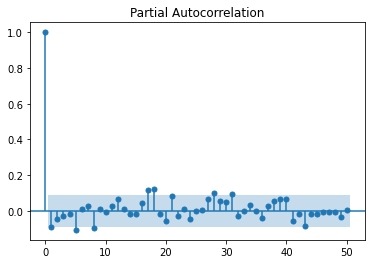

In [18]:
plot_pacf(df['premium'].diff().dropna(), lags=50);

Similarly to the acf model, there are not much significant spikes in the PACF plot. However, lags 17 and 18 shows a slightly more significant spike.

### Creating the ARIMA model

In [19]:
# Performing train test split on the data
train, test = train_test_split(
    df,
    test_size=0.2,
    shuffle=False
)

As we have identified that until lags 18 for both AR and MA models, I will perform a manual gridsearch on the ARIMA model to see which has the best performing hyperparameters

In [20]:
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

for p in range(19):
    for q in range(19):
        try:
            print(f'Attempting ARIMA({p}, 1, {q})')
            arima = ARIMA(endog=train['premium'], order=(p, 1, q), freq='SMS')
            model = arima.fit()
            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')
            if model.aic < best_aic:
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')


Attempting ARIMA(0, 1, 0)
The AIC for ARIMA(0,1,0) is: 7239.627411887577
Attempting ARIMA(0, 1, 1)
The AIC for ARIMA(0,1,1) is: 7239.572261721656
Attempting ARIMA(0, 1, 2)
The AIC for ARIMA(0,1,2) is: 7240.690599135505
Attempting ARIMA(0, 1, 3)
The AIC for ARIMA(0,1,3) is: 7241.578185512202
Attempting ARIMA(0, 1, 4)
The AIC for ARIMA(0,1,4) is: 7243.1364781393395
Attempting ARIMA(0, 1, 5)
The AIC for ARIMA(0,1,5) is: 7239.727233921691
Attempting ARIMA(0, 1, 6)
The AIC for ARIMA(0,1,6) is: 7241.745234438102
Attempting ARIMA(0, 1, 7)
The AIC for ARIMA(0,1,7) is: 7243.887430868598
Attempting ARIMA(0, 1, 8)
The AIC for ARIMA(0,1,8) is: 7244.097970602901
Attempting ARIMA(0, 1, 9)
The AIC for ARIMA(0,1,9) is: 7245.826864423069
Attempting ARIMA(0, 1, 10)
The AIC for ARIMA(0,1,10) is: 7247.744885767726
Attempting ARIMA(0, 1, 11)
The AIC for ARIMA(0,1,11) is: 7250.074820369962
Attempting ARIMA(0, 1, 12)
The AIC for ARIMA(0,1,12) is: 7247.717883415944
Attempting ARIMA(0, 1, 13)
The AIC for ARIMA

/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(1,1,2) is: 7239.143563996683
Attempting ARIMA(1, 1, 3)
The AIC for ARIMA(1,1,3) is: 7240.981268403932
Attempting ARIMA(1, 1, 4)
The AIC for ARIMA(1,1,4) is: 7242.80833100929
Attempting ARIMA(1, 1, 5)
The AIC for ARIMA(1,1,5) is: 7241.644235624173
Attempting ARIMA(1, 1, 6)
The AIC for ARIMA(1,1,6) is: 7243.739942748633
Attempting ARIMA(1, 1, 7)
The AIC for ARIMA(1,1,7) is: 7245.301432693565
Attempting ARIMA(1, 1, 8)
The AIC for ARIMA(1,1,8) is: 7246.015361413569
Attempting ARIMA(1, 1, 9)
The AIC for ARIMA(1,1,9) is: 7242.436255543534
Attempting ARIMA(1, 1, 10)
The AIC for ARIMA(1,1,10) is: 7244.6283734365525
Attempting ARIMA(1, 1, 11)
The AIC for ARIMA(1,1,11) is: 7247.086284368592
Attempting ARIMA(1, 1, 12)
The AIC for ARIMA(1,1,12) is: 7249.613632713646
Attempting ARIMA(1, 1, 13)
The AIC for ARIMA(1,1,13) is: 7251.452256155987
Attempting ARIMA(1, 1, 14)
The AIC for ARIMA(1,1,14) is: 7252.563367169847
Attempting ARIMA(1, 1, 15)
The AIC for ARIMA(1,1,15) is: 7250.42473

/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(2,1,2) is: 7240.877363320126
Attempting ARIMA(2, 1, 3)
The AIC for ARIMA(2,1,3) is: 7242.58543251974
Attempting ARIMA(2, 1, 4)
The AIC for ARIMA(2,1,4) is: 7244.705976033967
Attempting ARIMA(2, 1, 5)
The AIC for ARIMA(2,1,5) is: 7243.163769489001
Attempting ARIMA(2, 1, 6)
The AIC for ARIMA(2,1,6) is: 7241.762287455919
Attempting ARIMA(2, 1, 7)
The AIC for ARIMA(2,1,7) is: 7243.448997994054
Attempting ARIMA(2, 1, 8)
The AIC for ARIMA(2,1,8) is: 7245.26287222208
Attempting ARIMA(2, 1, 9)
The AIC for ARIMA(2,1,9) is: 7247.399806343643
Attempting ARIMA(2, 1, 10)
The AIC for ARIMA(2,1,10) is: 7250.4487205408095
Attempting ARIMA(2, 1, 11)
The AIC for ARIMA(2,1,11) is: 7248.7696453216195
Attempting ARIMA(2, 1, 12)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(2,1,12) is: 7246.889066308393
Attempting ARIMA(2, 1, 13)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(2,1,13) is: 7249.432816876806
Attempting ARIMA(2, 1, 14)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(2,1,14) is: 7249.429730758443
Attempting ARIMA(2, 1, 15)
The AIC for ARIMA(2,1,15) is: 7248.60681624596
Attempting ARIMA(2, 1, 16)
The AIC for ARIMA(2,1,16) is: 7254.321377235783
Attempting ARIMA(2, 1, 17)
The AIC for ARIMA(2,1,17) is: 7256.544914120555
Attempting ARIMA(2, 1, 18)
The AIC for ARIMA(2,1,18) is: 7257.544278329415
Attempting ARIMA(3, 1, 0)
The AIC for ARIMA(3,1,0) is: 7242.136477515187
Attempting ARIMA(3, 1, 1)
The AIC for ARIMA(3,1,1) is: 7240.797278313621
Attempting ARIMA(3, 1, 2)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(3,1,2) is: 7242.47756771362
Attempting ARIMA(3, 1, 3)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(3,1,3) is: 7237.750704519189
Attempting ARIMA(3, 1, 4)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(3,1,4) is: 7239.30365639738
Attempting ARIMA(3, 1, 5)
The AIC for ARIMA(3,1,5) is: 7240.805160977565
Attempting ARIMA(3, 1, 6)
The AIC for ARIMA(3,1,6) is: 7242.922297063622
Attempting ARIMA(3, 1, 7)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(3,1,7) is: 7245.140655427663
Attempting ARIMA(3, 1, 8)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(3,1,8) is: 7243.0543261998755
Attempting ARIMA(3, 1, 9)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(3,1,9) is: 7247.6401481438725
Attempting ARIMA(3, 1, 10)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(3,1,10) is: 7249.791125232126
Attempting ARIMA(3, 1, 11)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(3,1,11) is: 7254.339186837211
Attempting ARIMA(3, 1, 12)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(3,1,12) is: 7248.858800757673
Attempting ARIMA(3, 1, 13)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(3,1,13) is: 7251.0463056133885
Attempting ARIMA(3, 1, 14)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(3,1,14) is: 7252.239450658866
Attempting ARIMA(3, 1, 15)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(3,1,15) is: 7250.572529940213
Attempting ARIMA(3, 1, 16)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(3,1,16) is: 7253.058938928974
Attempting ARIMA(3, 1, 17)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(3,1,17) is: 7255.335933699873
Attempting ARIMA(3, 1, 18)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(3,1,18) is: 7259.245866221581
Attempting ARIMA(4, 1, 0)
The AIC for ARIMA(4,1,0) is: 7243.897827975763
Attempting ARIMA(4, 1, 1)
The AIC for ARIMA(4,1,1) is: 7242.441067338413
Attempting ARIMA(4, 1, 2)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(4,1,2) is: 7244.427680272931
Attempting ARIMA(4, 1, 3)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(4,1,3) is: 7239.612928411174
Attempting ARIMA(4, 1, 4)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(4,1,4) is: 7235.58197163953
Attempting ARIMA(4, 1, 5)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(4,1,5) is: 7238.977167505011
Attempting ARIMA(4, 1, 6)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(4,1,6) is: 7243.973411421013
Attempting ARIMA(4, 1, 7)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(4,1,7) is: 7245.349068164197
Attempting ARIMA(4, 1, 8)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(4,1,8) is: 7245.230680524239
Attempting ARIMA(4, 1, 9)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(4,1,9) is: 7247.525628351708
Attempting ARIMA(4, 1, 10)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(4,1,10) is: 7248.356501309947
Attempting ARIMA(4, 1, 11)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(4,1,11) is: 7251.042802216058
Attempting ARIMA(4, 1, 12)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(4,1,12) is: 7248.546852361695
Attempting ARIMA(4, 1, 13)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(4,1,13) is: 7252.281987439194
Attempting ARIMA(4, 1, 14)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(4,1,14) is: 7251.63749927648
Attempting ARIMA(4, 1, 15)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(4,1,15) is: 7256.026066550233
Attempting ARIMA(4, 1, 16)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(4,1,16) is: 7253.110419683966
Attempting ARIMA(4, 1, 17)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(4,1,17) is: 7255.122756899416
Attempting ARIMA(4, 1, 18)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(4,1,18) is: 7257.357671289797
Attempting ARIMA(5, 1, 0)
The AIC for ARIMA(5,1,0) is: 7240.250311043281
Attempting ARIMA(5, 1, 1)
The AIC for ARIMA(5,1,1) is: 7242.26315511563
Attempting ARIMA(5, 1, 2)
The AIC for ARIMA(5,1,2) is: 7243.787497833862
Attempting ARIMA(5, 1, 3)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(5,1,3) is: 7240.448243118106
Attempting ARIMA(5, 1, 4)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(5,1,4) is: 7240.258782795199
Attempting ARIMA(5, 1, 5)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(5,1,5) is: 7239.661504205778
Attempting ARIMA(5, 1, 6)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(5,1,6) is: 7242.909953422412
Attempting ARIMA(5, 1, 7)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(5,1,7) is: 7247.727035314923
Attempting ARIMA(5, 1, 8)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(5,1,8) is: 7248.147150658541
Attempting ARIMA(5, 1, 9)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(5,1,9) is: 7246.084615051102
Attempting ARIMA(5, 1, 10)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(5,1,10) is: 7244.751747944997
Attempting ARIMA(5, 1, 11)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(5,1,11) is: 7252.045817467303
Attempting ARIMA(5, 1, 12)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(5,1,12) is: 7249.198174678984
Attempting ARIMA(5, 1, 13)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(5,1,13) is: 7248.913223771033
Attempting ARIMA(5, 1, 14)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(5,1,14) is: 7251.723485671422
Attempting ARIMA(5, 1, 15)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(5,1,15) is: 7255.683388472193
Attempting ARIMA(5, 1, 16)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(5,1,16) is: 7254.638198396815
Attempting ARIMA(5, 1, 17)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(5,1,17) is: 7257.575306671478
Attempting ARIMA(5, 1, 18)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(5,1,18) is: 7259.348152494176
Attempting ARIMA(6, 1, 0)
The AIC for ARIMA(6,1,0) is: 7242.263099101707
Attempting ARIMA(6, 1, 1)
The AIC for ARIMA(6,1,1) is: 7244.278780875662
Attempting ARIMA(6, 1, 2)
The AIC for ARIMA(6,1,2) is: 7245.487028635288
Attempting ARIMA(6, 1, 3)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(6,1,3) is: 7242.343000765396
Attempting ARIMA(6, 1, 4)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(6,1,4) is: 7239.309252909677
Attempting ARIMA(6, 1, 5)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(6,1,5) is: 7241.751449098199
Attempting ARIMA(6, 1, 6)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(6,1,6) is: 7246.309892335921
Attempting ARIMA(6, 1, 7)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(6,1,7) is: 7248.832881058757
Attempting ARIMA(6, 1, 8)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(6,1,8) is: 7250.930532659156
Attempting ARIMA(6, 1, 9)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(6,1,9) is: 7248.167559810574
Attempting ARIMA(6, 1, 10)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(6,1,10) is: 7251.911071016426
Attempting ARIMA(6, 1, 11)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(6,1,11) is: 7251.133285287358
Attempting ARIMA(6, 1, 12)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(6,1,12) is: 7252.237141720946
Attempting ARIMA(6, 1, 13)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(6,1,13) is: 7252.26739186323
Attempting ARIMA(6, 1, 14)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(6,1,14) is: 7252.855206705806
Attempting ARIMA(6, 1, 15)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(6,1,15) is: 7257.435983270079
Attempting ARIMA(6, 1, 16)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(6,1,16) is: 7257.15787393856
Attempting ARIMA(6, 1, 17)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(6,1,17) is: 7259.423498677272
Attempting ARIMA(6, 1, 18)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(6,1,18) is: 7260.482358823095
Attempting ARIMA(7, 1, 0)
The AIC for ARIMA(7,1,0) is: 7244.217480427322
Attempting ARIMA(7, 1, 1)
The AIC for ARIMA(7,1,1) is: 7244.948530349884
Attempting ARIMA(7, 1, 2)
The AIC for ARIMA(7,1,2) is: 7244.505677201541
Attempting ARIMA(7, 1, 3)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(7,1,3) is: 7244.330379525638
Attempting ARIMA(7, 1, 4)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(7,1,4) is: 7241.332137068854
Attempting ARIMA(7, 1, 5)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(7,1,5) is: 7244.601343345627
Attempting ARIMA(7, 1, 6)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(7,1,6) is: 7249.343670202241
Attempting ARIMA(7, 1, 7)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(7,1,7) is: 7244.251615330292
Attempting ARIMA(7, 1, 8)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(7,1,8) is: 7247.497856027051
Attempting ARIMA(7, 1, 9)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(7,1,9) is: 7248.770979198575
Attempting ARIMA(7, 1, 10)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(7,1,10) is: 7252.267922777559
Attempting ARIMA(7, 1, 11)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(7,1,11) is: 7252.131109806154
Attempting ARIMA(7, 1, 12)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(7,1,12) is: 7254.116044495735
Attempting ARIMA(7, 1, 13)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(7,1,13) is: 7256.429385203135
Attempting ARIMA(7, 1, 14)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(7,1,14) is: 7256.284170812109
Attempting ARIMA(7, 1, 15)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(7,1,15) is: 7259.008645576054
Attempting ARIMA(7, 1, 16)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(7,1,16) is: 7259.372646509435
Attempting ARIMA(7, 1, 17)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(7,1,17) is: 7262.113325803093
Attempting ARIMA(7, 1, 18)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(7,1,18) is: 7262.6138619822805
Attempting ARIMA(8, 1, 0)
The AIC for ARIMA(8,1,0) is: 7242.603143247832
Attempting ARIMA(8, 1, 1)
The AIC for ARIMA(8,1,1) is: 7244.535762491141
Attempting ARIMA(8, 1, 2)
The AIC for ARIMA(8,1,2) is: 7246.534064601214
Attempting ARIMA(8, 1, 3)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(8,1,3) is: 7246.148246956578
Attempting ARIMA(8, 1, 4)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/op

The AIC for ARIMA(8,1,4) is: 7247.461803578293
Attempting ARIMA(8, 1, 5)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(8,1,5) is: 7248.189111924814
Attempting ARIMA(8, 1, 6)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(8,1,6) is: 7249.907835658914
Attempting ARIMA(8, 1, 7)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(8,1,7) is: 7246.663099446407
Attempting ARIMA(8, 1, 8)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(8,1,8) is: 7249.7810863995755
Attempting ARIMA(8, 1, 9)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(8,1,9) is: 7248.204005942556
Attempting ARIMA(8, 1, 10)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(8,1,10) is: 7253.0324870072145
Attempting ARIMA(8, 1, 11)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(8,1,11) is: 7254.960442054096
Attempting ARIMA(8, 1, 12)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(8,1,12) is: 7254.623448194722
Attempting ARIMA(8, 1, 13)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(8,1,13) is: 7255.188530657093
Attempting ARIMA(8, 1, 14)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(8,1,14) is: 7260.19293181017
Attempting ARIMA(8, 1, 15)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(8,1,15) is: 7260.2753014050795
Attempting ARIMA(8, 1, 16)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(8,1,16) is: 7259.989761882207
Attempting ARIMA(8, 1, 17)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(8,1,17) is: 7259.463786530782
Attempting ARIMA(8, 1, 18)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(8,1,18) is: 7264.571579774209
Attempting ARIMA(9, 1, 0)
The AIC for ARIMA(9,1,0) is: 7244.5579222292345
Attempting ARIMA(9, 1, 1)
The AIC for ARIMA(9,1,1) is: 7246.541399426441
Attempting ARIMA(9, 1, 2)
The AIC for ARIMA(9,1,2) is: 7248.540698656701
Attempting ARIMA(9, 1, 3)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(9,1,3) is: 7247.567854298415
Attempting ARIMA(9, 1, 4)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(9,1,4) is: 7244.5747771957285
Attempting ARIMA(9, 1, 5)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(9,1,5) is: 7246.785876539499
Attempting ARIMA(9, 1, 6)
The AIC for ARIMA(9,1,6) is: 7252.2969622444925
Attempting ARIMA(9, 1, 7)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/op

The AIC for ARIMA(9,1,7) is: 7247.584135498357
Attempting ARIMA(9, 1, 8)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(9,1,8) is: 7248.390419031747
Attempting ARIMA(9, 1, 9)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(9,1,9) is: 7250.532944697875
Attempting ARIMA(9, 1, 10)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(9,1,10) is: 7252.603837350623
Attempting ARIMA(9, 1, 11)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(9,1,11) is: 7255.222153883945
Attempting ARIMA(9, 1, 12)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(9,1,12) is: 7258.009840289861
Attempting ARIMA(9, 1, 13)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(9,1,13) is: 7257.423912753728
Attempting ARIMA(9, 1, 14)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(9,1,14) is: 7255.689488197453
Attempting ARIMA(9, 1, 15)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(9,1,15) is: 7254.301967844955
Attempting ARIMA(9, 1, 16)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(9,1,16) is: 7259.4484794341
Attempting ARIMA(9, 1, 17)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(9,1,17) is: 7253.283666541456
Attempting ARIMA(9, 1, 18)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(9,1,18) is: 7253.537001738317
Attempting ARIMA(10, 1, 0)
The AIC for ARIMA(10,1,0) is: 7246.482420916971
Attempting ARIMA(10, 1, 1)
The AIC for ARIMA(10,1,1) is: 7248.486219303782
Attempting ARIMA(10, 1, 2)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(10,1,2) is: 7240.952703249521
Attempting ARIMA(10, 1, 3)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(10,1,3) is: 7244.650005132665
Attempting ARIMA(10, 1, 4)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(10,1,4) is: 7245.388952426176
Attempting ARIMA(10, 1, 5)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(10,1,5) is: 7249.205755444074
Attempting ARIMA(10, 1, 6)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(10,1,6) is: 7251.276742770554
Attempting ARIMA(10, 1, 7)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(10,1,7) is: 7250.4701147110445
Attempting ARIMA(10, 1, 8)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(10,1,8) is: 7250.3777972366115
Attempting ARIMA(10, 1, 9)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(10,1,9) is: 7251.28822620719
Attempting ARIMA(10, 1, 10)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(10,1,10) is: 7253.8497250325545
Attempting ARIMA(10, 1, 11)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(10,1,11) is: 7256.067764196815
Attempting ARIMA(10, 1, 12)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(10,1,12) is: 7257.936400545819
Attempting ARIMA(10, 1, 13)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(10,1,13) is: 7256.903951349912
Attempting ARIMA(10, 1, 14)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(10,1,14) is: 7257.576331432629
Attempting ARIMA(10, 1, 15)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(10,1,15) is: 7259.924474633108
Attempting ARIMA(10, 1, 16)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(10,1,16) is: 7258.521874387953
Attempting ARIMA(10, 1, 17)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(10,1,17) is: 7254.124915835721
Attempting ARIMA(10, 1, 18)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(10,1,18) is: 7258.986694040279
Attempting ARIMA(11, 1, 0)
The AIC for ARIMA(11,1,0) is: 7248.3770991279525
Attempting ARIMA(11, 1, 1)
The AIC for ARIMA(11,1,1) is: 7249.40765531593
Attempting ARIMA(11, 1, 2)
The AIC for ARIMA(11,1,2) is: 7248.771264822253
Attempting ARIMA(11, 1, 3)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(11,1,3) is: 7250.798929567101
Attempting ARIMA(11, 1, 4)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(11,1,4) is: 7248.873727195691
Attempting ARIMA(11, 1, 5)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(11,1,5) is: 7251.0949209827895
Attempting ARIMA(11, 1, 6)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(11,1,6) is: 7252.231477016794
Attempting ARIMA(11, 1, 7)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(11,1,7) is: 7251.339902022842
Attempting ARIMA(11, 1, 8)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(11,1,8) is: 7252.416494912164
Attempting ARIMA(11, 1, 9)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(11,1,9) is: 7254.774196328124
Attempting ARIMA(11, 1, 10)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(11,1,10) is: 7256.481878669392
Attempting ARIMA(11, 1, 11)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(11,1,11) is: 7257.513316248294
Attempting ARIMA(11, 1, 12)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(11,1,12) is: 7259.974344004805
Attempting ARIMA(11, 1, 13)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(11,1,13) is: 7258.748328244363
Attempting ARIMA(11, 1, 14)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(11,1,14) is: 7260.857452502111
Attempting ARIMA(11, 1, 15)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(11,1,15) is: 7260.470147896736
Attempting ARIMA(11, 1, 16)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(11,1,16) is: 7260.632948522956
Attempting ARIMA(11, 1, 17)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(11,1,17) is: 7257.656231823039
Attempting ARIMA(11, 1, 18)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(11,1,18) is: 7261.90948502597
Attempting ARIMA(12, 1, 0)
The AIC for ARIMA(12,1,0) is: 7247.22785043661
Attempting ARIMA(12, 1, 1)
The AIC for ARIMA(12,1,1) is: 7249.23959233958
Attempting ARIMA(12, 1, 2)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(12,1,2) is: 7245.136868704878
Attempting ARIMA(12, 1, 3)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(12,1,3) is: 7247.156178226625
Attempting ARIMA(12, 1, 4)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(12,1,4) is: 7246.464472068832
Attempting ARIMA(12, 1, 5)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(12,1,5) is: 7248.469002968856
Attempting ARIMA(12, 1, 6)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(12,1,6) is: 7252.795698962871
Attempting ARIMA(12, 1, 7)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(12,1,7) is: 7250.307327897581
Attempting ARIMA(12, 1, 8)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(12,1,8) is: 7254.948570158573
Attempting ARIMA(12, 1, 9)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(12,1,9) is: 7253.899903540293
Attempting ARIMA(12, 1, 10)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(12,1,10) is: 7252.3721014434595
Attempting ARIMA(12, 1, 11)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(12,1,11) is: 7263.942101384671
Attempting ARIMA(12, 1, 12)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(12,1,12) is: 7261.996763711561
Attempting ARIMA(12, 1, 13)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(12,1,13) is: 7266.021252294237
Attempting ARIMA(12, 1, 14)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(12,1,14) is: 7263.884029803812
Attempting ARIMA(12, 1, 15)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(12,1,15) is: 7264.52188097761
Attempting ARIMA(12, 1, 16)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(12,1,16) is: 7263.05115127061
Attempting ARIMA(12, 1, 17)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(12,1,17) is: 7264.962309453729
Attempting ARIMA(12, 1, 18)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(12,1,18) is: 7263.257043999348
Attempting ARIMA(13, 1, 0)
The AIC for ARIMA(13,1,0) is: 7249.222111999702
Attempting ARIMA(13, 1, 1)
The AIC for ARIMA(13,1,1) is: 7251.090503475325
Attempting ARIMA(13, 1, 2)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(13,1,2) is: 7246.859097443957
Attempting ARIMA(13, 1, 3)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(13,1,3) is: 7249.278963706155
Attempting ARIMA(13, 1, 4)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(13,1,4) is: 7248.01143176466
Attempting ARIMA(13, 1, 5)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(13,1,5) is: 7249.855244238298
Attempting ARIMA(13, 1, 6)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(13,1,6) is: 7254.492830325629
Attempting ARIMA(13, 1, 7)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(13,1,7) is: 7250.094998887714
Attempting ARIMA(13, 1, 8)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(13,1,8) is: 7252.201768865818
Attempting ARIMA(13, 1, 9)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(13,1,9) is: 7255.076586517896
Attempting ARIMA(13, 1, 10)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(13,1,10) is: 7255.500065625476
Attempting ARIMA(13, 1, 11)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(13,1,11) is: 7262.93173033647
Attempting ARIMA(13, 1, 12)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(13,1,12) is: 7259.04648300085
Attempting ARIMA(13, 1, 13)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(13,1,13) is: 7262.887387056566
Attempting ARIMA(13, 1, 14)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(13,1,14) is: 7261.196023604532
Attempting ARIMA(13, 1, 15)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(13,1,15) is: 7263.396095978501
Attempting ARIMA(13, 1, 16)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(13,1,16) is: 7266.764441813133
Attempting ARIMA(13, 1, 17)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(13,1,17) is: 7265.335656733857
Attempting ARIMA(13, 1, 18)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(13,1,18) is: 7266.86331566727
Attempting ARIMA(14, 1, 0)
The AIC for ARIMA(14,1,0) is: 7250.338142745108
Attempting ARIMA(14, 1, 1)
The AIC for ARIMA(14,1,1) is: 7252.366912290499
Attempting ARIMA(14, 1, 2)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(14,1,2) is: 7250.8598481052995
Attempting ARIMA(14, 1, 3)
The AIC for ARIMA(14,1,3) is: 7253.886216002646
Attempting ARIMA(14, 1, 4)
The AIC for ARIMA(14,1,4) is: 7255.725178044277
Attempting ARIMA(14, 1, 5)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(14,1,5) is: 7255.142371675993
Attempting ARIMA(14, 1, 6)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(14,1,6) is: 7256.157177964193
Attempting ARIMA(14, 1, 7)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(14,1,7) is: 7250.6150899091335
Attempting ARIMA(14, 1, 8)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(14,1,8) is: 7253.299330768981
Attempting ARIMA(14, 1, 9)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(14,1,9) is: 7255.123092732612
Attempting ARIMA(14, 1, 10)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(14,1,10) is: 7254.197954996278
Attempting ARIMA(14, 1, 11)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(14,1,11) is: 7263.80433202855
Attempting ARIMA(14, 1, 12)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(14,1,12) is: 7259.7994895509255
Attempting ARIMA(14, 1, 13)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(14,1,13) is: 7265.6235033911
Attempting ARIMA(14, 1, 14)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(14,1,14) is: 7265.297351873295
Attempting ARIMA(14, 1, 15)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(14,1,15) is: 7264.154481089139
Attempting ARIMA(14, 1, 16)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(14,1,16) is: 7268.509791405671
Attempting ARIMA(14, 1, 17)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(14,1,17) is: 7266.459498350741
Attempting ARIMA(14, 1, 18)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(14,1,18) is: 7268.051875317526
Attempting ARIMA(15, 1, 0)
The AIC for ARIMA(15,1,0) is: 7252.3543007446715
Attempting ARIMA(15, 1, 1)
The AIC for ARIMA(15,1,1) is: 7254.316377109355
Attempting ARIMA(15, 1, 2)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(15,1,2) is: 7249.019472677452
Attempting ARIMA(15, 1, 3)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(15,1,3) is: 7252.233714323447
Attempting ARIMA(15, 1, 4)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(15,1,4) is: 7257.562669957822
Attempting ARIMA(15, 1, 5)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(15,1,5) is: 7251.904020226682
Attempting ARIMA(15, 1, 6)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(15,1,6) is: 7257.697567996242
Attempting ARIMA(15, 1, 7)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(15,1,7) is: 7253.2636969823925
Attempting ARIMA(15, 1, 8)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(15,1,8) is: 7255.188988074574
Attempting ARIMA(15, 1, 9)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(15,1,9) is: 7258.970413648785
Attempting ARIMA(15, 1, 10)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(15,1,10) is: 7256.706863013138
Attempting ARIMA(15, 1, 11)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(15,1,11) is: 7262.922256524649
Attempting ARIMA(15, 1, 12)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(15,1,12) is: 7265.551096331285
Attempting ARIMA(15, 1, 13)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(15,1,13) is: 7265.794046242179
Attempting ARIMA(15, 1, 14)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(15,1,14) is: 7272.619286211328
Attempting ARIMA(15, 1, 15)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(15,1,15) is: 7260.429266194475
Attempting ARIMA(15, 1, 16)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(15,1,16) is: 7265.489101687248
Attempting ARIMA(15, 1, 17)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(15,1,17) is: 7266.269586854696
Attempting ARIMA(15, 1, 18)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(15,1,18) is: 7267.390752321022
Attempting ARIMA(16, 1, 0)
The AIC for ARIMA(16,1,0) is: 7253.770361009088
Attempting ARIMA(16, 1, 1)
The AIC for ARIMA(16,1,1) is: 7250.8690476328875
Attempting ARIMA(16, 1, 2)
The AIC for ARIMA(16,1,2) is: 7252.887865994859
Attempting ARIMA(16, 1, 3)
The AIC for ARIMA(16,1,3) is: 7248.928203315831
Attempting ARIMA(16, 1, 4)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(16,1,4) is: 7250.205182265296
Attempting ARIMA(16, 1, 5)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(16,1,5) is: 7255.703109036248
Attempting ARIMA(16, 1, 6)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(16,1,6) is: 7256.605620664069
Attempting ARIMA(16, 1, 7)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(16,1,7) is: 7257.307465676486
Attempting ARIMA(16, 1, 8)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(16,1,8) is: 7259.892591793193
Attempting ARIMA(16, 1, 9)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(16,1,9) is: 7260.11473597467
Attempting ARIMA(16, 1, 10)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(16,1,10) is: 7258.304641573601
Attempting ARIMA(16, 1, 11)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(16,1,11) is: 7260.59842888884
Attempting ARIMA(16, 1, 12)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(16,1,12) is: 7263.766690281045
Attempting ARIMA(16, 1, 13)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(16,1,13) is: 7263.567093050362
Attempting ARIMA(16, 1, 14)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(16,1,14) is: 7261.773168221023
Attempting ARIMA(16, 1, 15)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(16,1,15) is: 7262.774775291972
Attempting ARIMA(16, 1, 16)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(16,1,16) is: 7267.915424944668
Attempting ARIMA(16, 1, 17)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(16,1,17) is: 7267.354390396851
Attempting ARIMA(16, 1, 18)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(16,1,18) is: 7268.214774277423
Attempting ARIMA(17, 1, 0)
The AIC for ARIMA(17,1,0) is: 7253.051436136639
Attempting ARIMA(17, 1, 1)
The AIC for ARIMA(17,1,1) is: 7252.77104403966
Attempting ARIMA(17, 1, 2)
The AIC for ARIMA(17,1,2) is: 7254.498424703155
Attempting ARIMA(17, 1, 3)
The AIC for ARIMA(17,1,3) is: 7250.887077917265
Attempting ARIMA(17, 1, 4)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(17,1,4) is: 7254.104756294766
Attempting ARIMA(17, 1, 5)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(17,1,5) is: 7254.9623047134255
Attempting ARIMA(17, 1, 6)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(17,1,6) is: 7258.870370314936
Attempting ARIMA(17, 1, 7)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(17,1,7) is: 7259.539521213658
Attempting ARIMA(17, 1, 8)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(17,1,8) is: 7253.970370847055
Attempting ARIMA(17, 1, 9)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(17,1,9) is: 7255.210276680447
Attempting ARIMA(17, 1, 10)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(17,1,10) is: 7253.564859519112
Attempting ARIMA(17, 1, 11)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(17,1,11) is: 7255.748621939805
Attempting ARIMA(17, 1, 12)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(17,1,12) is: 7260.914030856461
Attempting ARIMA(17, 1, 13)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(17,1,13) is: 7264.113042389532
Attempting ARIMA(17, 1, 14)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(17,1,14) is: 7262.311023112732
Attempting ARIMA(17, 1, 15)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(17,1,15) is: 7262.806982749386
Attempting ARIMA(17, 1, 16)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(17,1,16) is: 7263.392915517694
Attempting ARIMA(17, 1, 17)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(17,1,17) is: 7265.4787570794
Attempting ARIMA(17, 1, 18)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(17,1,18) is: 7264.313723004992
Attempting ARIMA(18, 1, 0)
The AIC for ARIMA(18,1,0) is: 7251.065591264671
Attempting ARIMA(18, 1, 1)
The AIC for ARIMA(18,1,1) is: 7252.988591227113
Attempting ARIMA(18, 1, 2)
The AIC for ARIMA(18,1,2) is: 7254.145878639158
Attempting ARIMA(18, 1, 3)
The AIC for ARIMA(18,1,3) is: 7254.76468269412
Attempting ARIMA(18, 1, 4)
The AIC for ARIMA(18,1,4) is: 7256.775826405036
Attempting ARIMA(18, 1, 5)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(18,1,5) is: 7256.585079292872
Attempting ARIMA(18, 1, 6)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(18,1,6) is: 7257.639634433973
Attempting ARIMA(18, 1, 7)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(18,1,7) is: 7255.242658977531
Attempting ARIMA(18, 1, 8)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(18,1,8) is: 7252.846992835966
Attempting ARIMA(18, 1, 9)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(18,1,9) is: 7251.921219372176
Attempting ARIMA(18, 1, 10)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(18,1,10) is: 7255.540713594599
Attempting ARIMA(18, 1, 11)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(18,1,11) is: 7255.7271833639015
Attempting ARIMA(18, 1, 12)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(18,1,12) is: 7259.453020611052
Attempting ARIMA(18, 1, 13)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(18,1,13) is: 7260.754841785396
Attempting ARIMA(18, 1, 14)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(18,1,14) is: 7261.240988109965
Attempting ARIMA(18, 1, 15)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(18,1,15) is: 7262.476172008461
Attempting ARIMA(18, 1, 16)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(18,1,16) is: 7263.400546445457
Attempting ARIMA(18, 1, 17)


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(18,1,17) is: 7268.558819386733
Attempting ARIMA(18, 1, 18)
The AIC for ARIMA(18,1,18) is: 7270.880744015683


MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(4,1,4).
This model has an AIC of 7235.58197163953.


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


After performing the gridsearch, the hyperparameters selected was (4, 1, 4)

/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


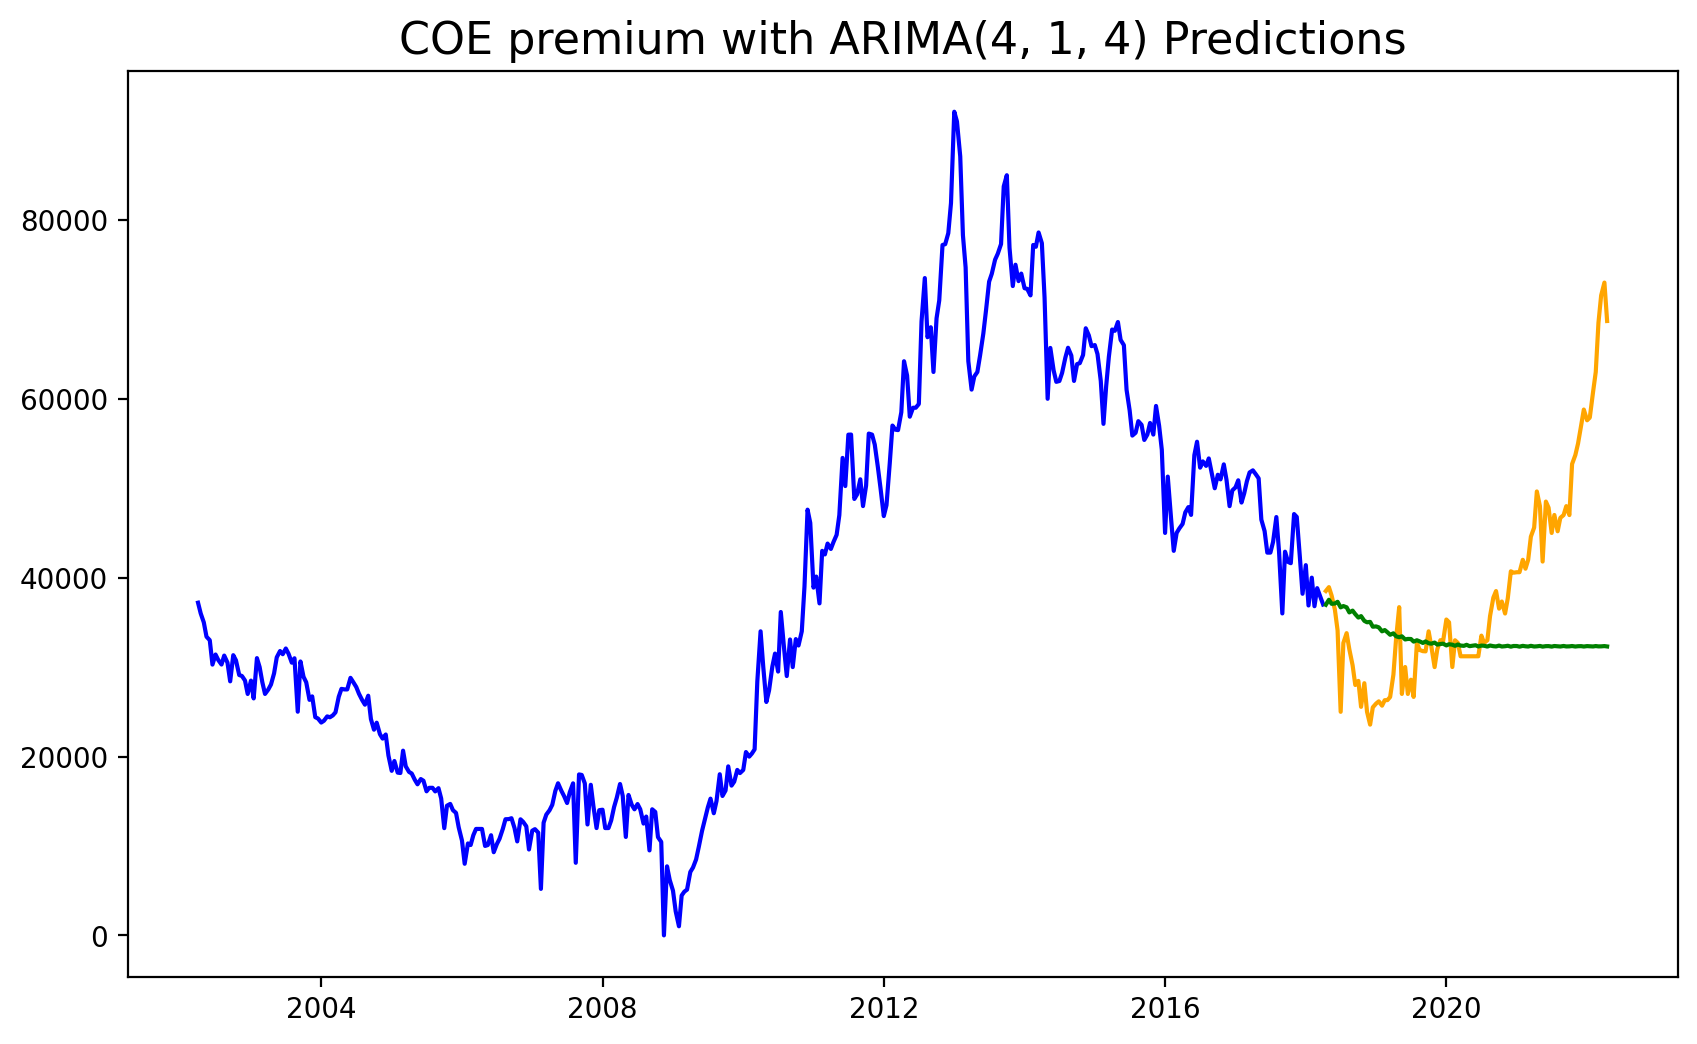

In [21]:
# Instantiate best model.
arima = ARIMA(endog=train['premium'], order=(4,1,4), freq='SMS')

# Fit ARIMA model.
model = arima.fit()

# Generate predictions based on test set.
preds = model.predict(
    start=test['premium'].index[0],
    end=test['premium'].index[-1]
)

# Plot data.
plt.figure(figsize=(10,6), dpi = 200)

# Plot training data.
plt.plot(train['premium'], color = 'blue')

# Plot testing data.
plt.plot(test['premium'], color = 'orange')

# Plot predicted test values.
plt.plot(preds, color = 'green')
plt.title(label = 'COE premium with ARIMA(4, 1, 4) Predictions', fontsize=16)

#plt.title(label = 'Once-Differenced Global Mean Temperature with ARIMA(3, 1, 3) Predictions', fontsize=16)
plt.show();

In [22]:
# Calculating the MSE for the model.
round(mean_squared_error(test['premium'], preds), 2)

170766416.86

The MSE of the ARIMA model is 170,766,416. It does not seem to fit the data very well.

As mentioned previously, I also want to take into account of the success rate of the predictions. 

My definition of success:
$$
\text{Predicted Premium} >= \text{Actual Premium}
$$


In [23]:
# Create a function to test for the success rate of the model.
def success_rate(actual_premium, predicted_premium):
    successful_bids = []
    actual_reset = actual_premium.reset_index(drop=True)
    for i in range(len(predicted_premium)):
        if predicted_premium[i] >= actual_reset[i]:
             successful_bids.append(actual_reset[i])
    return round((len(successful_bids) / len(actual_premium)) * 100, 1), len(successful_bids), len(actual_premium)

In [24]:
success_rate(test['premium'], preds)

(43.3, 42, 97)

The success rate of the model is at 43.3%. This is also not a successful model.

In [25]:
# Creating a summary df to collate the performance of the models
summary_df = pd.DataFrame(columns=['Model',
                                   'Univariate / Multivariate',
                                   'MSE',
                                   'Success %'
                                  ])

In [26]:
# Adding the model performance into the summary df.
summary_df.loc[1] = ['ARIMA',
                     'Univariate',
                     170766416.86,
                     43.3]

summary_df

,Model,Univariate / Multivariate,MSE,Success %
1,ARIMA,Univariate,1.707664e+08,43.3


In [27]:
# Creating a prediction df to collate the predicted premiums of each model
model_predict_df = pd.DataFrame(df['premium'][-97:])

In [28]:
# Adding the predictions of the arima model
model_predict_df['arima_prediction'] = preds
model_predict_df

,premium,arima_prediction
new_date,,
2018-04-15,38510.0,36973.069082
2018-05-01,38941.0,37531.802645
2018-05-15,38001.0,37075.139259
2018-06-01,36426.0,37112.638537
2018-06-15,34110.0,37300.409720
...,...,...
2022-02-15,63000.0,32352.617001
2022-03-01,68501.0,32315.851255
2022-03-15,71556.0,32319.609842


## Baseline model - Linear Regression

As the ARIMA model did not perform very well, the next model I wanted to try was a simple linear regression model. I will be using quota as the only predictor.

In [29]:
coe.set_index('new_date', inplace=True)
coe.sort_index(inplace=True)

In [30]:
# Creating the X and y
X = coe[['quota']]
y = coe['premium'] 

In [31]:
# Performing train test split on X and y
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    shuffle=False
)

In [32]:
# Performing Standard Scaling on the dataset
ss = StandardScaler()
ss.fit(X_train)

Z_train = ss.transform(X_train)
Z_test = ss.transform(X_test)


In [33]:
# Instantiating and fitting the model
lr = LinearRegression()
lr.fit(Z_train, y_train)

LinearRegression()

In [34]:
# Performing cross_val_score on the model.
- cross_val_score(
    lr,
    Z_train,
    y_train,
    cv=10,
    scoring='neg_mean_squared_error'
).mean()

311746129.76944613

In [35]:
# Calculating the MSE of the model
round(mean_squared_error(
    y_test,
    lr.predict(Z_test)
),2)

86105841.98

Looking at the cross val score and the MSE of the model, it can be seen that the model was overfitting as the values are vastly different. However, the MSE of the model improved significantly from the ARIMA model.

In [37]:
# Calculating the success rate of the model
success_rate(y_test, lr.predict(Z_test))

(83.5, 81, 97)

The model performed significantly well in successfully predict coe premiums.

In [39]:
# Adding the model performance to the summary table
summary_df.loc[2] = ['Linear Regression',
                     'Univariate',
                     86105841.98,
                     83.5]

summary_df

,Model,Univariate / Multivariate,MSE,Success %
1,ARIMA,Univariate,1.707664e+08,43.3
2,Linear Regression,Univariate,8.610584e+07,83.5


In [40]:
# Adding the predicted values of the LR model.
model_predict_df['LR_prediction'] = lr.predict(Z_test)
model_predict_df

,premium,arima_prediction,LR_prediction
new_date,,,
2018-04-15,38510.0,36973.069082,35261.761430
2018-05-01,38941.0,37531.802645,37976.419241
2018-05-15,38001.0,37075.139259,37997.141820
2018-06-01,36426.0,37112.638537,37852.083769
2018-06-15,34110.0,37300.409720,37748.470875
...,...,...,...
2022-02-15,63000.0,32352.617001,56606.017499
2022-03-01,68501.0,32315.851255,56709.630392
2022-03-15,71556.0,32319.609842,56460.959448


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


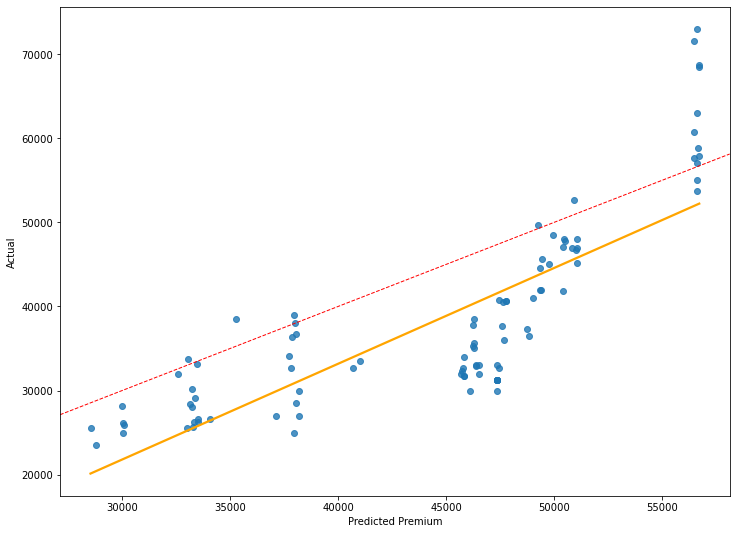

In [41]:
# Plotting the scatterplot of the linear regression line
plt.figure(figsize=(12,9))
sns.regplot('LR_prediction', 'premium',model_predict_df, ci=None, 
            line_kws = {'color': 'orange'} )

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='red', lw=1, scalex=False, scaley=False)

plt.xlabel('Predicted Premium')
plt.ylabel('Actual');

### Linear Regression Model 2

After the improvement using the LR model, I want to try and see if I will be able to use other variables to test predict coe premiums.

In [42]:
# Using lag data set for other variables
coe_lag.set_index('new_date', inplace=True)
coe_lag.sort_index(inplace=True)

In [43]:
# Creating X and y
X2 = coe_lag[['quota', 'cat_a_dereg', 'total_pop_growth', 'close']]
y2 = coe_lag['premium'] 

In [44]:
X2

,quota,cat_a_dereg,total_pop_growth,close
new_date,,,,
2002-04-01 00:00:00,1110.0,5038.0,2.7,1813.177000
2002-04-15 00:00:00,1149.0,5038.0,2.7,1799.878000
2002-05-01 00:00:00,1128.0,3883.0,2.7,1742.603333
2002-05-15 00:00:00,1111.0,3883.0,2.7,1776.763000
2002-06-01 00:00:00,1111.0,3103.0,2.7,1713.361667
...,...,...,...,...
2022-02-15 00:00:00,536.0,1383.0,-4.1,3213.605000
2022-03-01 00:00:00,531.0,1042.0,-4.1,3377.386000
2022-03-15 00:00:00,543.0,1042.0,-4.1,3389.226250


In [45]:
# Performing train test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2,
    y2,
    test_size=0.2,
    shuffle=False
)

In [46]:
# Performing Standard Scaling on the model
ss2 = StandardScaler()
ss2.fit(X_train2)

Z_train2 = ss2.transform(X_train2)
Z_test2 = ss2.transform(X_test2)


In [47]:
# Instatianting and fitting the model
lr2 = LinearRegression()
lr2.fit(Z_train2, y_train2)

LinearRegression()

In [48]:
# Calculating the cross val score
- cross_val_score(
    lr2,
    Z_train2,
    y_train2,
    cv=10,
    scoring='neg_mean_squared_error'
).mean()

150864176.14223725

In [49]:
# Calculating the MSE
mean_squared_error(
    y_test2,
    lr2.predict(Z_test2)
)

627776111.2357254

The MSE of the new LR model is significantly worse compared to the previous mLR model. This is expected as during the EDA, the models showed that the variables are not good estimators of coe premiums

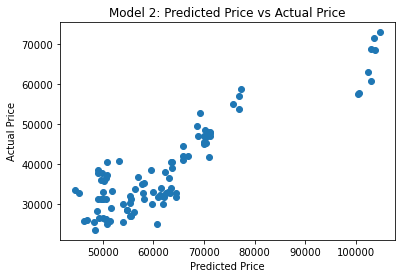

In [50]:
# Plotting the scatter plot for lr2
plt.scatter(lr2.predict(Z_test2), y_test2)
plt.title('Model 2: Predicted Price vs Actual Price')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price');

In [51]:
# Calculating the success rate
success_rate(y_test2, lr2.predict(Z_test2))

(100.0, 97, 97)

Suprisingly, while the model has a poor MSE, it was able to achieve a 100% success rate. 

In [52]:
# Adding the model performance to the summary df
summary_df.loc[3] = ['Linear Regression ',
                     'Multivariate',
                     627776111,
                     100.0]

summary_df

,Model,Univariate / Multivariate,MSE,Success %
1,ARIMA,Univariate,1.707664e+08,43.3
2,Linear Regression,Univariate,8.610584e+07,83.5
3,Linear Regression,Multivariate,6.277761e+08,100.0


In [53]:
# Adding the predictions of the LR2 model
model_predict_df['LR2_prediction'] = lr2.predict(Z_test2)
model_predict_df

,premium,arima_prediction,LR_prediction,LR2_prediction
new_date,,,,
2018-04-15,38510.0,36973.069082,35261.761430,59468.877307
2018-05-01,38941.0,37531.802645,37976.419241,63731.252825
2018-05-15,38001.0,37075.139259,37997.141820,62205.019922
2018-06-01,36426.0,37112.638537,37852.083769,63054.139799
2018-06-15,34110.0,37300.409720,37748.470875,63508.140858
...,...,...,...,...
2022-02-15,63000.0,32352.617001,56606.017499,102355.546378
2022-03-01,68501.0,32315.851255,56709.630392,103824.163085
2022-03-15,71556.0,32319.609842,56460.959448,103708.287040


As the model was performing quite badly, I will try using regularisation to improve the model.

In [54]:
# Instantiating a lasso regression
lasso = LassoCV(n_alphas=200)

In [55]:
# Fitting the lasso model
lasso.fit(Z_train2, y_train2)

# Calculating best alpha for the model
lasso.alpha_

15.41977491701277

In [56]:
# Instantiating the lasso model with best alpha
lasso_best = Lasso(alpha=lasso.alpha_)

In [57]:
# Calculating the cross val score
- cross_val_score(
    lasso_best,
    Z_train2,
    y_train2,
    cv=10,
    scoring='neg_mean_squared_error'
).mean()

151049415.30054897

In [58]:
# Refitting the lasso model
lasso_best.fit(Z_train2, y_train2)

# Calculating the mean squared error on the test data
mean_squared_error(
    y_test2,
    lasso_best.predict(Z_test2)
)

629132479.3382112

Unfortunately, the model did not perform any better with regularisation.

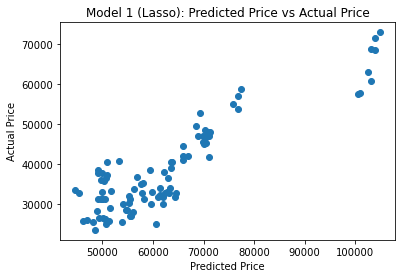

In [59]:
plt.scatter(lasso_best.predict(Z_test2), y_test2)
plt.title('Model 1 (Lasso): Predicted Price vs Actual Price')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price');

In [60]:
# Calculating the success rate
success_rate(y_test2, lasso_best.predict(Z_test2))

(100.0, 97, 97)

In [61]:
# Adding the model performance to the summary df
summary_df.loc[4] = ['Linear Regression w Lasso ',
                     'Multivariate',
                     629132479.33,
                     100.0]

summary_df

,Model,Univariate / Multivariate,MSE,Success %
1,ARIMA,Univariate,1.707664e+08,43.3
2,Linear Regression,Univariate,8.610584e+07,83.5
3,Linear Regression,Multivariate,6.277761e+08,100.0
4,Linear Regression w Lasso,Multivariate,6.291325e+08,100.0


In [62]:
# Adding the predictions of the Lasso model
model_predict_df['LR_lasso_prediction'] = lasso_best.predict(Z_test2)
model_predict_df

,premium,arima_prediction,LR_prediction,LR2_prediction,LR_lasso_prediction
new_date,,,,,
2018-04-15,38510.0,36973.069082,35261.761430,59468.877307,59428.305855
2018-05-01,38941.0,37531.802645,37976.419241,63731.252825,63629.527089
2018-05-15,38001.0,37075.139259,37997.141820,62205.019922,62114.592957
2018-06-01,36426.0,37112.638537,37852.083769,63054.139799,62953.126568
2018-06-15,34110.0,37300.409720,37748.470875,63508.140858,63403.870218
...,...,...,...,...,...
2022-02-15,63000.0,32352.617001,56606.017499,102355.546378,102453.053244
2022-03-01,68501.0,32315.851255,56709.630392,103824.163085,103941.579941
2022-03-15,71556.0,32319.609842,56460.959448,103708.287040,103826.827722


In [63]:
# Instantiating the ridge model
ridge = RidgeCV(alphas=np.logspace(0, 10, 200))

In [64]:
# Fitting the ridge model
ridge.fit(Z_train2, y_train2)

# Calculating best alpha for the model
ridge.alpha_

1.0

In [65]:
# Instantiating the ridge model again with the best alpha
ridge_best = Ridge(alpha=ridge.alpha_)

In [66]:
# Calculating the cross val score
- cross_val_score(
    ridge_best,
    Z_train2,
    y_train2,
    cv=10,
    scoring='neg_mean_squared_error'
).mean()

151018669.29801217

In [67]:
# Refitting the lasso model
ridge_best.fit(Z_train2, y_train2)

# Calculating the mean squared error on the test data
mean_squared_error(
    y_test2,
    ridge_best.predict(Z_test2)
)

629122991.38245

Unfortunately, ridge regularisation also did not improve the model as well.

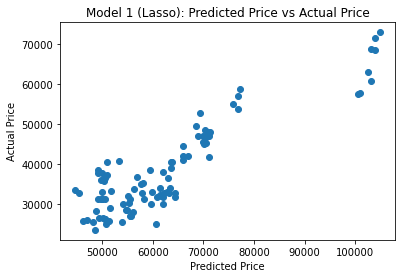

In [68]:
plt.scatter(ridge_best.predict(Z_test2), y_test2)
plt.title('Model 1 (Lasso): Predicted Price vs Actual Price')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price');

In [69]:
# Calculating the success rate
success_rate(y_test2, ridge_best.predict(Z_test2))

(100.0, 97, 97)

In [70]:
# Adding the model performance to the summary df
summary_df.loc[5] = ['Linear Regression w Ridge',
                     'Multivariate',
                     629122991.38,
                     100.0]

summary_df

,Model,Univariate / Multivariate,MSE,Success %
1,ARIMA,Univariate,1.707664e+08,43.3
2,Linear Regression,Univariate,8.610584e+07,83.5
3,Linear Regression,Multivariate,6.277761e+08,100.0
4,Linear Regression w Lasso,Multivariate,6.291325e+08,100.0
5,Linear Regression w Ridge,Multivariate,6.291230e+08,100.0


In [71]:
# Adding the predictions of the LR2 model
model_predict_df['LR_ridge_prediction'] = ridge_best.predict(Z_test2)
model_predict_df

,premium,arima_prediction,LR_prediction,LR2_prediction,LR_lasso_prediction,LR_ridge_prediction
new_date,,,,,,
2018-04-15,38510.0,36973.069082,35261.761430,59468.877307,59428.305855,59421.111810
2018-05-01,38941.0,37531.802645,37976.419241,63731.252825,63629.527089,63596.535593
2018-05-15,38001.0,37075.139259,37997.141820,62205.019922,62114.592957,62084.367498
2018-06-01,36426.0,37112.638537,37852.083769,63054.139799,62953.126568,62920.001840
2018-06-15,34110.0,37300.409720,37748.470875,63508.140858,63403.870218,63370.192926
...,...,...,...,...,...,...
2022-02-15,63000.0,32352.617001,56606.017499,102355.546378,102453.053244,102455.268294
2022-03-01,68501.0,32315.851255,56709.630392,103824.163085,103941.579941,103952.834847
2022-03-15,71556.0,32319.609842,56460.959448,103708.287040,103826.827722,103838.986591


## SARIMA Modelling

As Linear regression with multiple variables did not perform well, I decided to turn SARIMA model to see if that i will be able to use seasonality to improve the ARIMA model

In [72]:
df['premium']

new_date
2002-04-01    37201.0
2002-04-15    36000.0
2002-05-01    35000.0
2002-05-15    33401.0
2002-06-01    33009.0
               ...   
2022-02-15    63000.0
2022-03-01    68501.0
2022-03-15    71556.0
2022-04-01    72996.0
2022-04-15    68699.0
Freq: SMS-15, Name: premium, Length: 482, dtype: float64

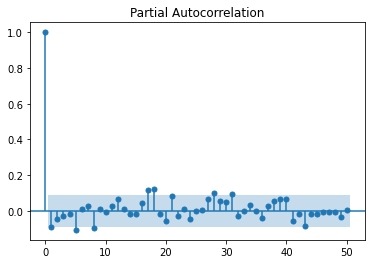

In [73]:
plot_pacf(df['premium'].diff().dropna(), lags=50);

Using the pacf plot, I can see that there is a significant spike in the 18th lag. Hence, I will be using a seasonality of 18 time steps.

In [74]:
# Instantiate Sarima model with seasonality of 18
sarima = SARIMAX(endog=train['premium'],
                  order=(4, 1, 4),              
                  seasonal_order=(0, 1, 4, 18))

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
# Start at time period 150 and end at 187.
preds = model.predict(start=y_test.index[0], end=y_test.index[-1])

# Evaluate predictions.
mse = mean_squared_error(y_test, preds)
print(f'This model has an MSE of {mse}.')

/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.10675D+00    |proj g|=  6.86491D-02


 This problem is unconstrained.



At iterate    5    f=  9.09200D+00    |proj g|=  2.18039D-02

At iterate   10    f=  9.08997D+00    |proj g|=  2.20212D-03

At iterate   15    f=  9.08958D+00    |proj g|=  1.44781D-03

At iterate   20    f=  9.08845D+00    |proj g|=  9.89816D-03

At iterate   25    f=  9.08803D+00    |proj g|=  2.65034D-03

At iterate   30    f=  9.08709D+00    |proj g|=  2.20252D-02

At iterate   35    f=  9.08624D+00    |proj g|=  1.58946D-02

At iterate   40    f=  9.08606D+00    |proj g|=  9.58908D-04

At iterate   45    f=  9.08603D+00    |proj g|=  1.34711D-03

At iterate   50    f=  9.08603D+00    |proj g|=  3.95683D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


This model has an MSE of 151149668.91542795.


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


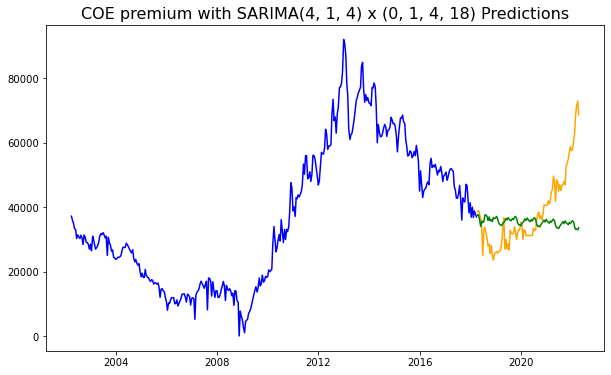

In [75]:
# Plotting the sarima model
plt.figure(figsize=(10,6))
plt.plot(train['premium'], color = 'blue')
plt.plot(test['premium'], color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'COE premium with SARIMA(4, 1, 4) x (0, 1, 4, 18) Predictions', fontsize=16)
plt.show();

In [76]:
# Calculating the success rate
success_rate(test['premium'], preds)

(50.5, 49, 97)

Both the MSE and success rate was unable to outperform the simple Linear Regression model

In [77]:
# Adding the model performance to the summary df
summary_df.loc[6] = ['SARIMA',
                     'Univariate',
                     151149668.92,
                     50.5]

summary_df

,Model,Univariate / Multivariate,MSE,Success %
1,ARIMA,Univariate,1.707664e+08,43.3
2,Linear Regression,Univariate,8.610584e+07,83.5
3,Linear Regression,Multivariate,6.277761e+08,100.0
4,Linear Regression w Lasso,Multivariate,6.291325e+08,100.0
5,Linear Regression w Ridge,Multivariate,6.291230e+08,100.0
6,SARIMA,Univariate,1.511497e+08,50.5


In [78]:
# Adding the predictions of the SARIMA model
model_predict_df['sarima'] = preds
model_predict_df

,premium,arima_prediction,LR_prediction,LR2_prediction,LR_lasso_prediction,LR_ridge_prediction,sarima
new_date,,,,,,,
2018-04-15,38510.0,36973.069082,35261.761430,59468.877307,59428.305855,59421.111810,37501.079337
2018-05-01,38941.0,37531.802645,37976.419241,63731.252825,63629.527089,63596.535593,37695.429140
2018-05-15,38001.0,37075.139259,37997.141820,62205.019922,62114.592957,62084.367498,36091.692690
2018-06-01,36426.0,37112.638537,37852.083769,63054.139799,62953.126568,62920.001840,34009.095681
2018-06-15,34110.0,37300.409720,37748.470875,63508.140858,63403.870218,63370.192926,35692.918409
...,...,...,...,...,...,...,...
2022-02-15,63000.0,32352.617001,56606.017499,102355.546378,102453.053244,102455.268294,33880.996720
2022-03-01,68501.0,32315.851255,56709.630392,103824.163085,103941.579941,103952.834847,33110.258191
2022-03-15,71556.0,32319.609842,56460.959448,103708.287040,103826.827722,103838.986591,33257.284965


As the performance of the SARIMA model did not significantly improve on the performance and that the variables did not also improve on the model performance, I did not attempt a SARIMA model with exogenous variables.

In [79]:
# Saving the summary table to csv
summary_df.to_csv('../data/summary_table.csv', index=False)

In [80]:
# Saving the prediction datat to csv
model_predict_df.to_csv('../data/predicted_value.csv', index=False)

## Please proceed to the next notebook for more modelling